# Prediction vs inference

In modelling, there is a tradeoff between interpretability and prediction. One cares about the $\hat{\beta}$ the other care about the $\hat{y}$

If we care purely about predictive power, we can sacrifice all interpretability of the $\hat{\beta}$ (eg. neural networks). On the other hand, linear models are perfectly interpretable.

One way we can boost predicting power for a simple model is the "kitchen sink" method -- creating as many features (one-hot, polynomial, interactions, etc.) as possible and cramming them into the model.

# 1. Iterative P-Value method

The first method is simple:

1. Start with as many features as possible

2. fit

3. Remove statistically insignificant features

4. Go to 2 until there arent features to remove

You can also verify by R2, log likelihood, AIC and BIC -- sometimes statistically insignificant features help in aggregate.

# 2. Regularization

The introduction of features like polynomial functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting.

For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

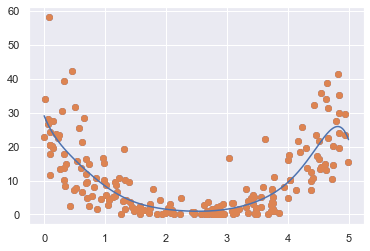

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

POLY_DEGREE = 9

rng = np.random.RandomState(1)
x = 5 * rng.rand(200)
y = np.square(2 * x - 5 + rng.randn(200))
plt.scatter(x, y)

# make_pipeline is going to be taught in the data engineering module
# For now understand it links transformer functions into each other
model = make_pipeline(PolynomialFeatures(POLY_DEGREE),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
xfit = np.linspace(0, 5, 1000)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

Note that when the polynomial degree is low (2-5) it fits well, but model artifacts (squiggly lines and crazy out-of-sample extraploations) happen for high-degree polynomials.

With the data projected to the high-dimensional polynomial, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator:

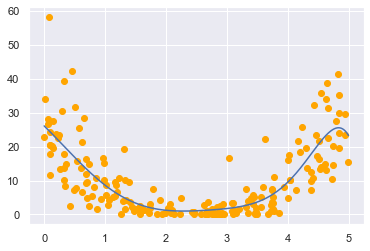

In [12]:
from sklearn.linear_model import Ridge
sns.set()

model = make_pipeline(PolynomialFeatures(9), Ridge(alpha=0.3))
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y, color='orange')
xfit = np.linspace(0, 5, 1000)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

You can also do regularized regression from statsmodels:

In [25]:
import statsmodels.api as sm

X = PolynomialFeatures(15).fit_transform(x[:, np.newaxis], y)
est = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha=0.2, L1_wt=1.0)

However, note that regularized regression doesn't have coefficient interpretability:

In [28]:
est.summary()

NotImplementedError: 

### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

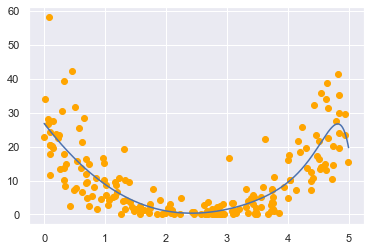

In [29]:
from sklearn.linear_model import Lasso
model = make_pipeline(PolynomialFeatures(30), Lasso(alpha=0.001))
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y, color='orange')
xfit = np.linspace(0, 5, 1000)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions.

So this is similar to doing manual feature selection, except in an automated manner.

As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty.

### ElasticNet

Elasticnet is in between L1 and L2 with a parameter (with 0 being L1 and 1 being L2 and the rest in between). You can see this being what's used in the `fit_regularized` from statsmodels.